In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn
from glob import glob

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue,construct_delta2

In [2]:
dataset = read_fatahi_dataset("../data/fatahi.xlsx")
len(dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

18

In [3]:
def solve_dataset(dataset):
    for problem in trange(len(dataset)):
        if f'solutions/gamma_{problem}.npy' not in glob('solutions/*'):
            print(problem)
            delta, gamma, status, value = mip_solve(dataset[problem])
            print(status)
            if status.name in ["OPTIMAL", 'FEASIBLE']:
                print('save!')
                np.save(f'solutions/gamma_{problem}.npy', gamma)
                np.save(f'solutions/delta_{problem}.npy', delta)

In [4]:
solve_dataset(dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

6


In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class GraphDataset(Dataset):
    def __init__(self, problems, gammas, deltas):
        self.problems = problems
        self.gammas = gammas
        self.deltas = deltas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]
        gamma = self.gammas[idx]
        delta = self.deltas[idx]

        graph, mask = dglgraph(problem, gamma, delta)
        graph.edata["feat"][os_type][:, 0] /= 10
        graph.edata["feat"][ss_type] /= 100

        return graph, gamma, delta, mask

In [3]:
train_problem = dataset[0]
test_problem = dataset[2]
train_problem["name"], test_problem["name"]

('5,10,10-1', '5,10,10-3')

In [4]:
train_delta, train_gamma, status, value = mip_solve(train_problem)
print(f'Problem {train_problem["name"]}: {value:.2f}, {status}')

np.save('gamma_0.npy', train_gamma)
np.save('delta_0.npy', train_delta)

train_gamma = np.load('gamma_0.npy')
train_delta = np.load('delta_0.npy')

In [15]:
test_delta, test_gamma, status, value = mip_solve(test_problem)
print(f'Problem {test_problem["name"]}: {value:.2f}, {status}')

# np.save('gamma_1.npy', test_gamma)
# np.save('delta_1.npy', test_delta)

# test_gamma = np.load('gamma_1.npy')
# test_delta = np.load('delta_1.npy')

Problem 5,10,10-3: 6202.45, OptimizationStatus.OPTIMAL


In [6]:
train_graph, mask_train = dglgraph(train_problem, train_gamma, train_delta)
train_target = train_graph.edata["target"][os_type]
delta_train_target = train_graph.edata["delta_target"][ss_type]
train_graph.edata["feat"][os_type][:, 0] /= 10
train_graph.edata["feat"][ss_type] /= 100

test_graph, mask_test = dglgraph(test_problem, test_gamma, test_delta)
test_target = test_graph.edata["target"][os_type]
delta_test_target = test_graph.edata["delta_target"][ss_type]
test_graph.edata["feat"][os_type][:, 0] /= 10
test_graph.edata["feat"][ss_type] /= 100

In [40]:
model = GNN(train_graph, 15, 1)
loss2 = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
train_objvalue = []
test_objvalue = []

optim = Adam(model.parameters(), lr=0.005)
for i in trange(500):
    logits, delta_logits = model(train_graph)
    loss = F.binary_cross_entropy_with_logits(logits, train_target)
    serv = loss2(delta_logits[mask_train], delta_train_target[mask_train])
    loss = loss + serv
    optim.zero_grad()
    loss.backward()
    optim.step()

    if i % 10 == 0:
        with torch.no_grad():
            train_loss.append(loss.item())
            pred_gamma, pred_delta = model.predict(train_graph, train_problem)
            train_objvalue.append(
                objvalue(train_problem, pred_gamma, pred_delta)
            )
            logits, delta_logits = model(test_graph)
            loss = F.binary_cross_entropy_with_logits(logits, test_target)
            serv = loss2(delta_logits[mask_test], delta_test_target[mask_test])
            loss = loss + serv
            test_loss.append(loss.item())
            pred_gamma, pred_delta = model.predict(test_graph, test_problem)
            test_objvalue.append(
                objvalue(test_problem, pred_gamma, pred_delta)
            )


  0%|          | 0/500 [00:00<?, ?it/s]

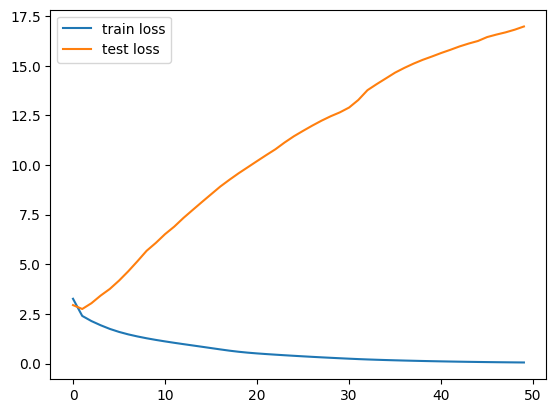

In [41]:
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

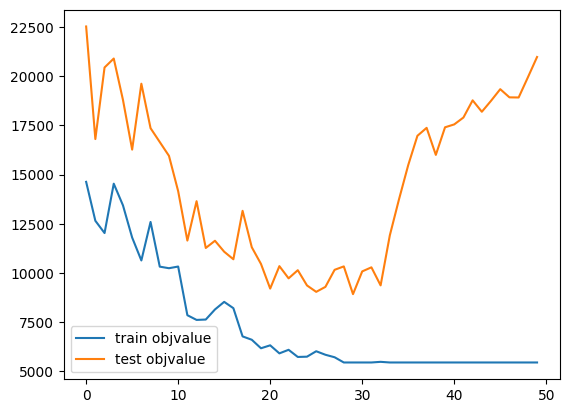

In [42]:
plt.plot(train_objvalue, label="train objvalue")
plt.plot(test_objvalue, label="test objvalue")
plt.legend()
plt.show()

In [43]:
min(test_objvalue)

8918.132268485997

In [44]:
min(train_objvalue)

5442.746695386337